Relaxations of parametric and bilevel polynomial optimization problems
========================================
Suppose we are interested in finding the global optimum of the following constrained polynomial optimization problem:

$$ \min_{x\in\mathbb{R}^n}f(x)$$
such that
$$ g_i(x) \geq 0, i=1,\ldots,r$$

Here $f$ and $g_i$ are polynomials in $x$. We can think of the constraints as a semialgebraic set $\mathbf{K}=\{x\in\mathbb{R}^n: g_i(x) \geq 0, i=1,\ldots,r\}$. [Lasserre's method](http://dx.doi.org/10.1137/S1052623400366802) gives a series of semidefinite programming (SDP) relaxation of increasing size that approximate this optimum through the moments of $x$.

A [manuscript](http://arxiv.org/abs/1506.02099) appeared on arXiv a few months ago that considers bilevel polynomial optimization problems, that is, when a set of variables is subject to a lower level optimization. The method heavily relies on the [joint+marginal approach](http://dx.doi.org/10.1137/090759240) to SDP relaxations of parametric polynomial optimization problems. Here we discuss both methods and how they can be implemented with [Ncpol2sdpa](http://ncpol2sdpa.readthedocs.org)>=1.10 in Python.

Constraints on moments
------------------------------

Let us consider the plainest form of the SDP relaxation first with the the following trivial polynomial optimization problem:

$$ \min_{x\in \mathbb{R}}2x^2$$

Let us denote the linear mapping from monomials to $\mathbb{R}$ by $L_x$. Then, for instance, $L_x(2x^2)= 2y_2$. If there is a representing Borel measure $\mu$ on the semialgebraic set $\mathbf{K}$ of the constraints (in this case, there are no constraints), then we can write $y_\alpha = \int_\mathbf{K} x^\alpha \mathrm{d}\mu$. The level-1 relaxation will be

$$ \min_{y}2y_{2}$$
such that
$$\left[ \begin{array}{cc}1 & y_{1} \\y_{1} & y_{2}\end{array} \right] \succeq{}0.$$

We import some functions first that we will use later:

In [1]:
import matplotlib.pyplot as plt
from math import sqrt
from sympy import integrate, N
from ncpol2sdpa import SdpRelaxation, generate_variables, flatten
%matplotlib inline 

Not surprisingly, solving the example gives a very accurate result:

In [2]:
x = generate_variables('x')[0]
sdp = SdpRelaxation([x])
sdp.get_relaxation(1, objective=x**2)
sdp.solve()
print(sdp.primal, sdp.dual)

1.5990354545454662e-08 -1.5990354545454556e-08


Notice that even in this formulation, there is an implicit constraint on a moment: the top left element of the moment matrix is 1. Given a representing measure, this means that $\int_\mathbf{K} \mathrm{d}\mu=1$. It is actually because of this that a $\lambda$ dual variable appears in the dual formulation:
$$max_{\lambda, \sigma_0} \lambda$$
such that
$$2x^2 - \lambda = \sigma_0\\
\sigma_0\in \Sigma{[x]}, \mathrm{deg}\sigma_0\leq 2.$$

In fact, we can move $\lambda$ to the right-hand side, where the sum-of-squares (SOS) decomposition is, $\lambda$ being a trivial SOS multiplied by the constraint $\int_\mathbf{K} \mathrm{d}\mu$, that is, by 1.

We normally think of adding some $g_i(x)$ polynomial constraints that define a semialgebraic set, and then constructing matching localizing matrices. We can, however, impose more constraints on the moments. For instance, we can add a constraint that $\int_\mathbf{K} x\mathrm{d}\mu = 1$. All of these constraints will have a constant instead of an SOS polynomial in the dual. To ensure the moments are not substituted out while generating the SDP, we enter them as pairs of moment inequalities. Solving this problem gives the correct result again:

In [3]:
moments = [x-1, 1-x]
sdp = SdpRelaxation([x])
sdp.get_relaxation(1, objective=x**2, momentinequalities=moments)
sdp.solve()
print(sdp.primal, sdp.dual)

1.0000006249546196 0.9999997167810939


The dual changed, slightly. Let $\gamma_\beta=\int_\mathbf{K} x^\beta\mathrm{d}\mu$ for $\beta=0, 1$. Then the dual reads as

$$max_{\lambda_\beta, \sigma_0} \sum_{\beta=0}^1\lambda_\beta \gamma_\beta$$
such that
$$2x^2 - \sum_{\beta=0}^1\lambda_\beta x^\beta = \sigma_0\\
\sigma_0\in \Sigma{[x]}, \mathrm{deg}\sigma_0\leq 2.$$

Indeed, if we extract the coefficients, we will see that $x$ gets a $\lambda_1=2$ (note that equalities are replaced by pairs of inequalities):

In [4]:
coeffs = [-sdp.extract_dual_value(0, range(1))]
coeffs += [sdp.y_mat[2*i+1][0][0] - sdp.y_mat[2*i+2][0][0]
           for i in range(len(moments)//2)]
sigma_i = sdp.get_sos_decomposition()
print(coeffs, [sdp.dual, sigma_i[1]-sigma_i[2]])

[1.0, 2.0] [0.9999997167810939, 2.00000000000000]


Moment constraints play a crucial role in the joint+marginal approach of the SDP relaxation of polynomial optimization problems, and hence also indirectly in the bilevel polynomial optimization problems.

Joint+marginal approach
-------------------------------
In a parametric polynomial optimization problem, we can separate two sets of variables, and one set acts as a parameter to the problem. More formally, we would like to find the following function:

$$ J(x) = \inf_{y\in\mathbb{R}^m}\{f(x,y): h_j(y)\geq 0, j=1,\ldots,r\},$$

where $x\in\mathbf{X}=\{x\in \mathbb{R}^n: h_k(x)\geq 0, k=r+1,\ldots,t\}$. This [can be relaxed](http://dx.doi.org/10.1137/090759240) as an SDP, and we can extract an approximation $J_k(x)$ at level-$k$ from the dual solution. The primal form reads as

$$ \mathrm{inf}_z L_z(f)$$
such that
$$ M_k(z)\succeq 0,\\
M_{k-v_j}(h_j z)\succeq 0, j=1,\ldots,t\\
L_z(x^\beta) = \gamma_\beta, \forall\beta\in\mathbb{N}_k^n.$$

Notice that the localizing matrices also address the polynomial constraints that define the semialgebraic set $\mathbf{X}$. If the positivity constraints are fulfilled, then we have a finite Borel representing measure $\mu$ on $\mathbf{K}=\{h_j(y)\geq 0, j=1,\ldots,r\}$ such that $z_{\alpha\beta}=\int_\mathbf{K} x^\alpha y^\beta\mathrm{d}\mu$. 

The part that is different from the regular Lasserre hierachy is the last line, where $\gamma_\beta=\int_\mathbf{X} x^\beta\mathrm{d}\varphi(x)$. This establishes a connection between the moments of $x$ on $\mathbf{K}$ in measure $\mu$ and the moments of $x$ on $\mathbf{X}$ in measure $\varphi$. This $\varphi$ measure is a Borel probability measure on $\mathbf{X}$ with a positive density with respect to the Lebesgue measure on $\mathbb{R}^n$. In other words, the marginal of one measure must match the other on $\mathbf{X}$.

The dual of the primal form of the SDP with these moment constraints is

$$ \mathrm{sup}_{p, \sigma_i} \int_\mathbf{X} p \mathrm{d}\varphi$$
such that
$$ f - p = \sigma_0 + \sum_{j=1}^t \sigma_j h_j\
p\in\mathbb{R}[x], \sigma_j\in\Sigma[x, y], j=0,\ldots,t\\
\mathrm{deg} p\leq 2k, \mathrm{deg} \sigma_0\leq 2k, \mathrm{deg}\sigma_j h_j \leq 2k, j=1,\ldots, t.
$$

The polynomial $p=\sum_{\beta=0}^{2k} \lambda_\beta x^\beta$ is the approximation $J_k(x)$. Below we reproduce the three examples of the paper.

*Example 1*

Let $\mathbf{X}=[0,1]$, $\mathbf{K}=\{(x,y): 1-x^2-y^2\geq 0; x,y\in\mathbf{X}\}$, and $f(x,y)= - xy^2$. We know that $J(x) = -1(1-x^2)x$. First we declare $J(x)$, a helper function to define a polynomial, and we set up the symbolic variables $x$ and $y$.

In [5]:
def J(x):
    return -(1-x**2)*x


def Jk(x, coeffs):
    return sum(ci*x**i for i, ci in enumerate(coeffs))

x = generate_variables('x')[0]
y = generate_variables('y')[0]

Next, we define the level of the relaxation and the moment constraints:

In [6]:
level = 4
gamma = [integrate(x**i, (x, 0, 1)) for i in range(1, 2*level+1)]
marginals = flatten([[x**i-N(gamma[i-1]), N(gamma[i-1])-x**i] for i in range(1, 2*level+1)])

Finally we define the objective function and the constraints that define the semialgebraic sets, and we generate and solve the relaxation.

In [7]:
f = -x*y**2
inequalities = [1.0-x**2-y**2, 1-x, x, 1-y, y]

sdp = SdpRelaxation([x, y], verbose=0)
sdp.get_relaxation(level, objective=f, momentinequalities=marginals,
                   inequalities=inequalities)
sdp.solve()
print(sdp.primal, sdp.dual, sdp.status)
coeffs = [sdp.extract_dual_value(0, range(len(inequalities)+1))]
coeffs += [sdp.y_mat[len(inequalities)+1+2*i][0][0] - sdp.y_mat[len(inequalities)+1+2*i+1][0][0]
           for i in range(len(marginals)//2)]

-0.25003374095299485 -0.2500337409529949 optimal


To check the correctness of the approximation, we plot the optimal and the approximated functions over the domain.

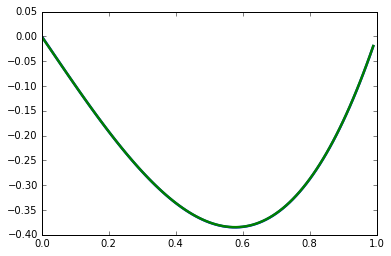

In [8]:
x_domain = [i/100. for i in range(100)]
plt.plot(x_domain, [J(xi) for xi in x_domain], linewidth=2.5)
plt.plot(x_domain, [Jk(xi, coeffs) for xi in x_domain], linewidth=2.5)
plt.show()

*Example 2*

The set $\mathbf{X}=[0,1]$  remains the same. Let $\mathbf{K}=\{(x,y): 1-y_1^2-y_2^2\geq 0\}$, and $f(x,y) = xy_1 + (1-x)y_2$. Now the optimal $J(x)$ will be $-\sqrt{x^2+(1-x)^2}$.

-0.8116610109835365 -0.8116610109835365 optimal


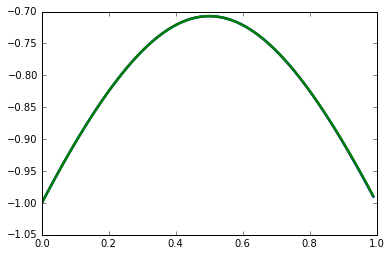

In [9]:
def J(x):
    return -sqrt(x**2+(1-x)**2)

x = generate_variables('x')[0]
y = generate_variables('y', 2)

f = x*y[0] + (1-x)*y[1]

gamma = [integrate(x**i, (x, 0, 1)) for i in range(1, 2*level+1)]
marginals = flatten([[x**i-N(gamma[i-1]), N(gamma[i-1])-x**i] for i in range(1, 2*level+1)])
inequalities = [1-y[0]**2-y[1]**2, x, 1-x]
sdp = SdpRelaxation(flatten([x, y]))
sdp.get_relaxation(level, objective=f, momentinequalities=marginals,
                   inequalities=inequalities)
sdp.solve()
print(sdp.primal, sdp.dual, sdp.status)
coeffs = [sdp.extract_dual_value(0, range(len(inequalities)+1))]
coeffs += [sdp.y_mat[len(inequalities)+1+2*i][0][0] - sdp.y_mat[len(inequalities)+1+2*i+1][0][0]
           for i in range(len(marginals)//2)]
plt.plot(x_domain, [J(xi) for xi in x_domain], linewidth=2.5)
plt.plot(x_domain, [Jk(xi, coeffs) for xi in x_domain], linewidth=2.5)
plt.show()

*Example 3*

Note that this is Example 4 in the paper. The set $\mathbf{X}=[0,1]$  remains the same, whereas $\mathbf{K}=\{(x,y): xy_1^2+y_2^2-x= 0,  y_1^2+xy_2^2-x= 0\}$, and $f(x,y) = (1-2x)(y_1+y_2)$. The optimal $J(x)$ is $-2|1-2x|\sqrt{x/(1+x)}$. We enter the equalities as pairs of inequalities.

-0.535187880633569 -0.535188348622651 near_optimal


/home/pwittek/.local/lib/python3.5/site-packages/mosek/__init__.py:5463: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if barxj_ != None:
/home/pwittek/.local/lib/python3.5/site-packages/mosek/__init__.py:5498: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if barsj_ != None:


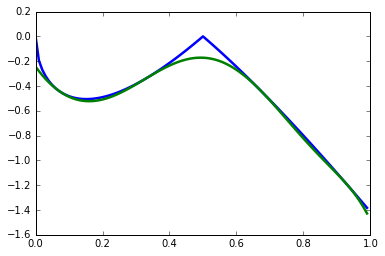

In [10]:
def J(x):
    return -2*abs(1-2*x)*sqrt(x/(1+x))

x = generate_variables('x')[0]
y = generate_variables('y', 2)
f = (1-2*x)*(y[0] + y[1])

gamma = [integrate(x**i, (x, 0, 1)) for i in range(1, 2*level+1)]
marginals = flatten([[x**i-N(gamma[i-1]), N(gamma[i-1])-x**i] for i in range(1, 2*level+1)])

inequalities = [x*y[0]**2 + y[1]**2 - x,  - x*y[0]**2 - y[1]**2 + x,
                y[0]**2 + x*y[1]**2 - x,  - y[0]**2 - x*y[1]**2 + x,
                1-x, x]
sdp = SdpRelaxation(flatten([x, y]))
sdp.get_relaxation(level, objective=f, momentinequalities=marginals,
                   inequalities=inequalities)
sdp.solve(solver="mosek")
print(sdp.primal, sdp.dual, sdp.status)
coeffs = [sdp.extract_dual_value(0, range(len(inequalities)+1))]
coeffs += [sdp.y_mat[len(inequalities)+1+2*i][0][0] - sdp.y_mat[len(inequalities)+1+2*i+1][0][0]
           for i in range(len(marginals)//2)]
plt.plot(x_domain, [J(xi) for xi in x_domain], linewidth=2.5)
plt.plot(x_domain, [Jk(xi, coeffs) for xi in x_domain], linewidth=2.5)
plt.show()

Bilevel problem of nonconvex lower level
------------------------------------------------------
We define the bilevel problem as follows:
$$ \min_{x\in\mathbb{R}^n, y\in\mathbb{R}^m}f(x,y)$$
such that
$$g_i(x, y) \geq 0, i=1,\ldots,s,\\
y\in Y(x)=\mathrm{argmin}_{w\in\mathbb{R}^m}\{G(x,w): h_j(w)\geq 0, j=1,...,r\}.$$

The more interesting case is when the when the lower level problem's objective function $G(x,y)$ is nonconvex. We consider the $\epsilon$-approximation of this case:

$$ \min_{x\in\mathbb{R}^n, y\in\mathbb{R}^m}f(x,y)$$
such that
$$g_i(x, y) \geq 0, i=1,\ldots,s,\\
h_j(y) \geq 0, j=1,\dots, r,\\
G(x,y) - \mathrm{min}_{w\in\mathbb{R}^m}\{G(x,w): h_j(w)\geq 0, j=1,...,r\}\leq \epsilon.$$

This approximation will give an [increasing lower bound](http://arxiv.org/abs/1506.02099)) on the original problem. The min function on the right of $G(x,y)$ is essentially a parametric polynomial optimization problem, that is, our task is to find $J(x)$. We have to ensure that the parameter set is compact, so we add a set of constraints on the coordinates of $x$: $\{M^2-x_l^2\geq 0, l=1,\ldots,n\}$ for some $M>0$.

The idea is that we relax this as an SDP at some level $k$ and fixed $\epsilon$ to obtain the following single-level polynomial optimization problem:
$$ \min_{x\in\mathbb{R}^n, y\in\mathbb{R}^m}f(x,y)$$
such that
$$g_i(x, y) \geq 0, i=1,\ldots,s,\\
h_j(y) \geq 0, j=1,\dots, r,\\
G(x,y) - J_k(x)\leq \epsilon.$$

Then we relax this is an another SDP at level $k$.

Consider a test problem defined as follows:
$$ \min_{(x,y)\in\mathbb{R}^2} x+y$$
such that
$$x\in[-1,1], \\
y\in \mathrm{argmin}_{w\in\mathbb{R}^m}\{\frac{xy^2}{2}-\frac{y^3}{3}, y\in[-1,1]\}$$.

This is clearly a bilevel problem. We set up the necessary variables and constraints, requesting a level-3 relaxation, and also fixing $\epsilon$ and a choice of $M$.

In [11]:
x = generate_variables('x')[0]
y = generate_variables('y')[0]

f = x + y
g = [x <= 1.0, x >= -1.0]
G = x*y**2/2.0 - y**3/3.0
h = [y <= 1.0, y >= -1.0]
epsilon = 0.001
M = 1.0
level = 3

We define the relaxation of the parametric polynomial optimization problem that returns an approximation of $J(x)$ from the dual:

In [12]:
def lower_level(k, G, h, M):
    gamma = [integrate(x**i, (x, -M, M))/(2*M) for i in range(1, 2*k+1)]
    marginals = flatten([[x**i-N(gamma[i-1]), N(gamma[i-1])-x**i] for i in range(1, 2*k+1)])
    inequalities = h + [x**2 <= M**2]
    lowRelaxation = SdpRelaxation([x, y])
    lowRelaxation.get_relaxation(k, objective=G,
                                 momentinequalities=marginals,
                                 inequalities=inequalities)
    lowRelaxation.solve()
    print("Low-level:", lowRelaxation.primal, lowRelaxation.dual, lowRelaxation.status)
    coeffs = []
    for i in range(len(marginals)//2):
        coeffs.append(lowRelaxation.y_mat[len(inequalities)+1+2*i][0][0] -
                      lowRelaxation.y_mat[len(inequalities)+1+2*i+1][0][0])
    blocks = [i for i in range(len(inequalities)+1)]
    constant = lowRelaxation.extract_dual_value(0, blocks)
    return constant + sum(ci*x**(i+1) for i, ci in enumerate(coeffs))

Finally, we put it all together:

In [13]:
Jk = lower_level(level, G, h, M)
inequalities = g + h + [G - Jk <= epsilon]
highRelaxation = SdpRelaxation([x, y], verbose=0)
highRelaxation.get_relaxation(level, objective=f,
                              inequalities=inequalities)
highRelaxation.solve()
print("High-level:", highRelaxation.primal, highRelaxation.status)
print("Optimal x and y:", highRelaxation[x], highRelaxation[y])


Low-level: -0.3506176102365808 -0.3506180235695789 unknown
High-level: -0.0027997294093268232 unknown
Optimal x and y: -1.0 0.9972


These values are close to the analytical solution.